### 1. IMPORTATION ET EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
df = pd.read_csv('donnees_financieres_completes_flux.csv')

print("=== EXPLORATION INITIALE ===")
print(f"Dimensions : {df.shape}")
print(f"Répartition des défauts : {df['defaut'].value_counts()}")
print(f"Taux de défaut : {(df['defaut'] == 'oui').mean():.2%}")

=== EXPLORATION INITIALE ===
Dimensions : (6510, 8)
Répartition des défauts : defaut
non    5500
oui    1010
Name: count, dtype: int64
Taux de défaut : 15.51%


### 2. ANALYSE STATISTIQUE ET VISUALISATION

=== STATISTIQUES DESCRIPTIVES ===
        company_id         year  account_code        amount
count  6510.000000  6510.000000   6510.000000  6.510000e+03
mean     60.539785  2021.999693   1907.956989  2.276755e+05
std      34.684176     0.816183   2499.531307  4.386638e+05
min       1.000000  2021.000000    101.000000  0.000000e+00
25%      30.000000  2021.000000    411.000000  3.652825e+04
50%      61.000000  2022.000000    641.000000  1.011800e+05
75%      91.000000  2023.000000   2111.000000  2.508860e+05
max     120.000000  2023.000000   7011.000000  9.686281e+06


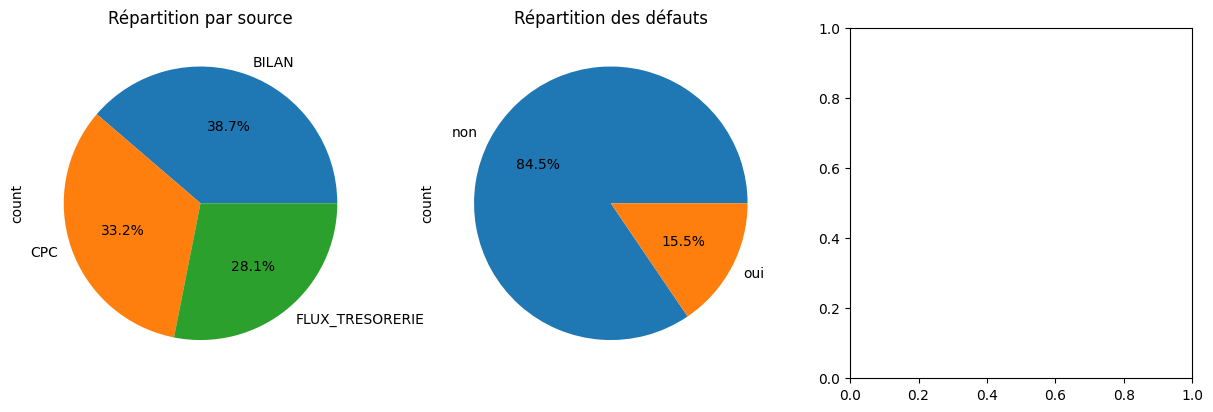

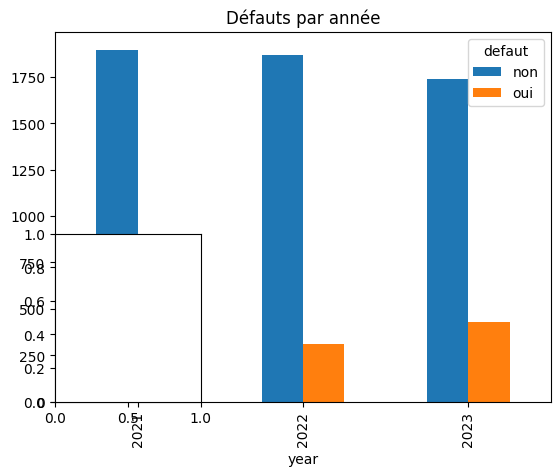

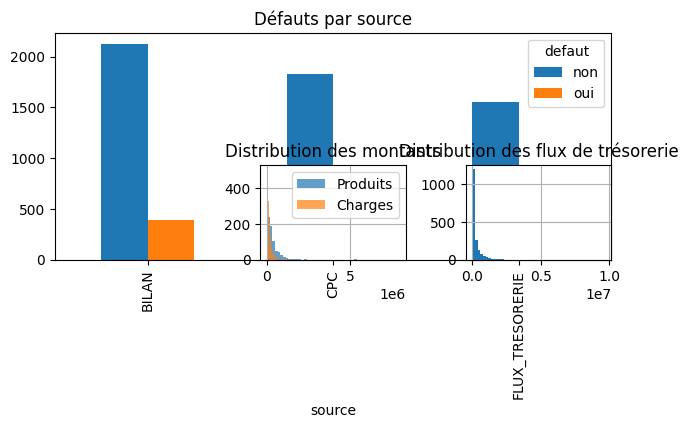

In [2]:
# Statistiques descriptives
print("=== STATISTIQUES DESCRIPTIVES ===")
print(df.describe())

# Répartition par source et défaut
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['source'].value_counts().plot.pie(autopct='%1.1f%%', title='Répartition par source')

plt.subplot(2, 3, 2)
df['defaut'].value_counts().plot.pie(autopct='%1.1f%%', title='Répartition des défauts')

plt.subplot(2, 3, 3)
df.groupby(['year', 'defaut']).size().unstack().plot(kind='bar', title='Défauts par année')

plt.subplot(2, 3, 4)
df.groupby(['source', 'defaut']).size().unstack().plot(kind='bar', title='Défauts par source')

# Distribution des montants
plt.subplot(2, 3, 5)
df[df['nature'] == 'produit']['amount'].hist(bins=50, alpha=0.7, label='Produits')
df[df['nature'] == 'charge']['amount'].hist(bins=50, alpha=0.7, label='Charges')
plt.legend()
plt.title('Distribution des montants')

plt.subplot(2, 3, 6)
df[df['source'] == 'FLUX_TRESORERIE']['amount'].hist(bins=50)
plt.title('Distribution des flux de trésorerie')

plt.tight_layout()
plt.show()

### 3. FEATURE ENGINEERING

In [3]:
# Agrégation des données par entreprise et année
def preparer_features(df):
    features_list = []
    
    for (company_id, year), group in df.groupby(['company_id', 'year']):
        features = {'company_id': company_id, 'year': year}
        
        # Agrégation par source et nature
        # CPC - Compte de résultat
        cpc_data = group[group['source'] == 'CPC']
        if not cpc_data.empty:
            features['ventes_total'] = cpc_data[cpc_data['nature'] == 'produit']['amount'].sum()
            features['charges_total'] = cpc_data[cpc_data['nature'] == 'charge']['amount'].sum()
            features['resultat_net'] = features['ventes_total'] - features['charges_total']
            features['marge_nette'] = features['resultat_net'] / features['ventes_total'] if features['ventes_total'] > 0 else 0
        
        # BILAN - Ratios financiers
        bilan_data = group[group['source'] == 'BILAN']
        if not bilan_data.empty:
            features['actif_total'] = bilan_data[bilan_data['nature'] == 'actif']['amount'].sum()
            features['passif_total'] = bilan_data[bilan_data['nature'] == 'passif']['amount'].sum()
            features['endettement'] = features['passif_total'] / features['actif_total'] if features['actif_total'] > 0 else 0
            features['fond_roulement'] = features['actif_total'] - features['passif_total']
        
        # FLUX_TRESORERIE - Ratios de liquidité
        flux_data = group[group['source'] == 'FLUX_TRESORERIE']
        if not flux_data.empty:
            features['flux_exploitation'] = flux_data[flux_data['nature'] == 'encaissement']['amount'].sum() - \
                                          flux_data[flux_data['nature'] == 'decaissement_exploitation']['amount'].sum()
            features['flux_investissement'] = flux_data[flux_data['nature'] == 'investissement']['amount'].sum()
            features['flux_financement'] = flux_data[flux_data['nature'] == 'financement']['amount'].sum()
            features['flux_tresorerie_net'] = features['flux_exploitation'] + features['flux_investissement'] + features['flux_financement']
            features['capacite_autofinancement'] = features['flux_exploitation'] / features['ventes_total'] if features['ventes_total'] > 0 else 0
        
        # Variable cible (prend la valeur de défaut de l'entreprise cette année)
        features['defaut'] = group['defaut'].iloc[0]
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Préparation des features
features_df = preparer_features(df)
print("=== FEATURES GÉNÉRÉES ===")
print(f"Dimensions features : {features_df.shape}")
print(f"Colonnes : {list(features_df.columns)}")
print(f"Répartition défauts dans features : {features_df['defaut'].value_counts()}")

=== FEATURES GÉNÉRÉES ===
Dimensions features : (360, 16)
Colonnes : ['company_id', 'year', 'ventes_total', 'charges_total', 'resultat_net', 'marge_nette', 'actif_total', 'passif_total', 'endettement', 'fond_roulement', 'flux_exploitation', 'flux_investissement', 'flux_financement', 'flux_tresorerie_net', 'capacite_autofinancement', 'defaut']
Répartition défauts dans features : defaut
non    304
oui     56
Name: count, dtype: int64


### 4. GESTION DE L'ÉQUILIBRE DES CLASSES

In [4]:
# Séparation des features et target
X = features_df.drop(['company_id', 'year', 'defaut'], axis=1)
y = features_df['defaut'].map({'oui': 1, 'non': 0})  # Conversion en numérique

print("=== ANALYSE DU DÉSÉQUILIBRE ===")
print(f"Distribution des classes : {y.value_counts()}")
print(f"Taux de défaut : {y.mean():.2%}")

# Techniques de rééchantillonnage
print("\n=== TECHNIQUES D'EQUILIBRAGE ===")

# SMOTE (Sur-échantillonnage)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print(f"Après SMOTE - Distribution : {pd.Series(y_smote).value_counts()}")

# Under-sampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
print(f"Après Under-sampling - Distribution : {pd.Series(y_under).value_counts()}")

# Combinaison SMOTE + Under-sampling
smote_under = SMOTE(sampling_strategy=0.5, random_state=42)
X_comb, y_comb = smote_under.fit_resample(X, y)
print(f"Après combinaison - Distribution : {pd.Series(y_comb).value_counts()}")

=== ANALYSE DU DÉSÉQUILIBRE ===
Distribution des classes : defaut
0    304
1     56
Name: count, dtype: int64
Taux de défaut : 15.56%

=== TECHNIQUES D'EQUILIBRAGE ===
Après SMOTE - Distribution : defaut
0    304
1    304
Name: count, dtype: int64
Après Under-sampling - Distribution : defaut
0    56
1    56
Name: count, dtype: int64
Après combinaison - Distribution : defaut
0    304
1    152
Name: count, dtype: int64


### 5. DIVISION TRAIN/TEST ET PRÉPROCESSING

In [5]:
# Division train/test sur les données originales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("=== DIVISION TRAIN/TEST ===")
print(f"Train set : {X_train.shape}, Défauts : {y_train.mean():.2%}")
print(f"Test set : {X_test.shape}, Défauts : {y_test.mean():.2%}")

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Application de SMOTE seulement sur le training set
X_train_balanced, y_train_balanced = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
print(f"Training set après SMOTE : {X_train_balanced.shape}")

=== DIVISION TRAIN/TEST ===
Train set : (252, 13), Défauts : 15.48%
Test set : (108, 13), Défauts : 15.74%
Training set après SMOTE : (426, 13)


### 6. MODÉLISATION ET COMPARAISON

In [6]:
# Définition des modèles
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Entraînement et évaluation
results = {}

for name, model in models.items():
    print(f"\n=== ENTRAÎNEMENT {name} ===")
    
    # Entraînement sur données équilibrées
    model.fit(X_train_balanced, y_train_balanced)
    
    # Prédictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Métriques
    auc_score = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        'model': model,
        'auc': auc_score,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall: {report['1']['recall']:.4f}")
    print(f"F1-Score: {report['1']['f1-score']:.4f}")


=== ENTRAÎNEMENT Logistic Regression ===
AUC: 0.7033
Precision: 0.2895
Recall: 0.6471
F1-Score: 0.4000

=== ENTRAÎNEMENT Random Forest ===
AUC: 0.6842
Precision: 0.3529
Recall: 0.3529
F1-Score: 0.3529

=== ENTRAÎNEMENT Gradient Boosting ===
AUC: 0.7214
Precision: 0.3000
Recall: 0.3529
F1-Score: 0.3243

=== ENTRAÎNEMENT SVM ===
AUC: 0.6716
Precision: 0.2593
Recall: 0.4118
F1-Score: 0.3182


### 7. ÉVALUATION ET COMPARAISON DES MODÈLES

=== COMPARAISON DES MODÈLES ===
                 Model     AUC  Precision  Recall  F1-Score
0  Logistic Regression  0.7033     0.2895  0.6471    0.4000
1        Random Forest  0.6842     0.3529  0.3529    0.3529
2    Gradient Boosting  0.7214     0.3000  0.3529    0.3243
3                  SVM  0.6716     0.2593  0.4118    0.3182


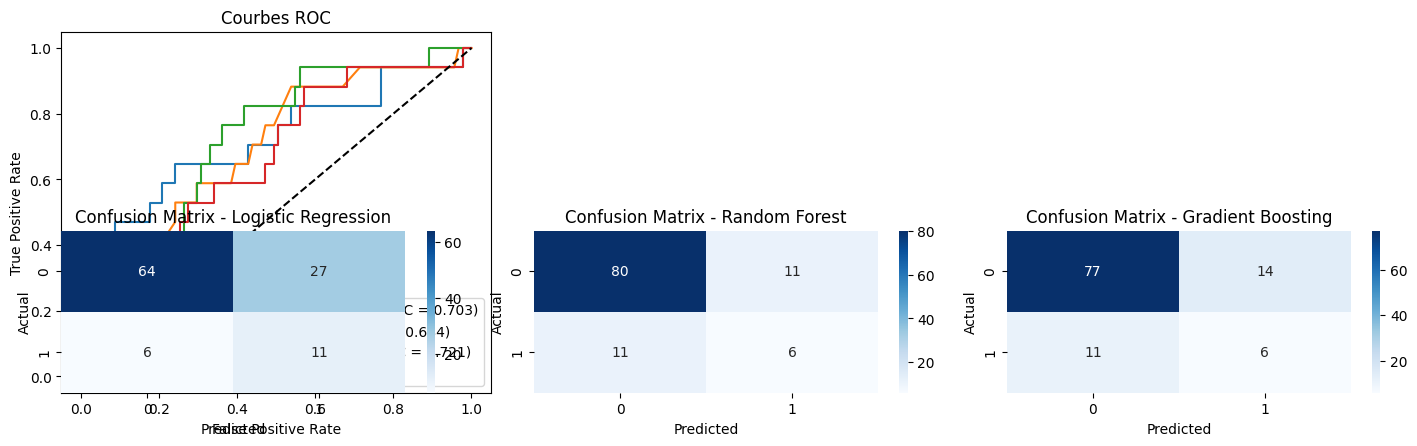

In [7]:
# Comparaison des modèles
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC': [results[m]['auc'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results]
})

print("=== COMPARAISON DES MODÈLES ===")
print(comparison_df.round(4))

# Visualisation des performances
plt.figure(figsize=(15, 5))

# Courbes ROC
plt.subplot(1, 3, 1)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['model'].predict_proba(X_test_scaled)[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend()

# Matrices de confusion
for i, (name, result) in enumerate(list(results.items())[:3]):
    plt.subplot(2, 3, i+4)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### 8. OPTIMISATION DES HYPERPARAMÈTRES

In [9]:
# Optimisation du meilleur modèle
print("=== OPTIMISATION DU MEILLEUR MODÈLE ===")

best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"Meilleur modèle : {best_model_name}")

# Initialisation des variables
best_model = None
param_grid = {}

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 4, 5]
    }
    best_model = GradientBoostingClassifier(random_state=42)

# Ajoutez d'autres modèles si nécessaire
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    best_model = LogisticRegression(random_state=42)

elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    best_model = SVC(random_state=42)

# Vérifier si un modèle a été sélectionné
if best_model is None:
    print(f"Modèle {best_model_name} non pris en charge pour l'optimisation.")
else:
    # Recherche par grille
    grid_search = GridSearchCV(
        best_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )

    # Application de SMOTE dans un pipeline
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', grid_search)
    ])

    pipeline.fit(X_train, y_train)

    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    print(f"Meilleur score F1 : {grid_search.best_score_:.4f}")

=== OPTIMISATION DU MEILLEUR MODÈLE ===
Meilleur modèle : Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Meilleur score F1 : 0.7210


### 9. SAUVEGARDE DU MODÈLE FINAL

In [10]:
import joblib

# Entraînement du modèle final avec les meilleurs paramètres
final_model = grid_search.best_estimator_

# Sauvegarde du modèle et du scaler
joblib.dump(final_model, 'modele_risque_credit.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("=== MODÈLE FINAL SAUVEGARDÉ ===")
print(f"Performance sur test set : {final_model.score(X_test_scaled, y_test):.4f}")

# Features importance (si Random Forest ou Gradient Boosting)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== IMPORTANCE DES VARIABLES ===")
    print(feature_importance.head(10))

=== MODÈLE FINAL SAUVEGARDÉ ===
Performance sur test set : 0.7500
